In [1]:
import pandas as pd
import numpy as np
import textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
import statsmodels.api as sm
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jfern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jfern\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
dirpath1 = 'C:\\Users\\jfern\\Desktop\\OMSCS\\Data Analytics\\Project\\Post_ID\\'
dirpath2 = 'C:\\Users\\jfern\\Desktop\\OMSCS\\Data Analytics\\Project\\Post\\'
dirpath3 = 'C:\\Users\\jfern\\Desktop\\OMSCS\\Data Analytics\\Project\\Comments\\'

post_id = pd.DataFrame()
for file in os.listdir(dirpath1):
    post_id = post_id .append(pd.read_json(os.path.join(dirpath1, file)))
post_id.to_csv("Post_ID.csv") 
    
df_posts = pd.DataFrame()
for file in os.listdir(dirpath2):
    df_posts=df_posts.append(pd.read_json(os.path.join(dirpath2, file)))
df_posts.to_csv("Posts.csv") 
    
df_comments = pd.DataFrame()
for file in os.listdir(dirpath3):
    df_comments= df_comments.append(pd.read_json(os.path.join(dirpath3, file)))
df_comments.to_csv("Comments.csv") 



In [2]:
df=pd.read_csv("Comments.csv",parse_dates=['created_utc'])
df = df.rename(columns={'created_utc': 'Date'})
df["post_id"]=df["link_id"].str.split("_").str[-1]

In [7]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english", ignore_stopwords=True)
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")

def sentiment_calc(text):
    try:
        token=tokenizer.tokenize(text.lower())
        words=[lemmatizer.lemmatize(w) for w in token if w not in stop_words]
        stem_text=" ".join([stemmer.stem(i) for i in words])
        return TextBlob(stem_text).sentiment.polarity
    except:
        return None

def subjectivity_calc(text):
    try:
        token=tokenizer.tokenize(text.lower())
        words=[lemmatizer.lemmatize(w) for w in token if w not in stop_words]
        stem_text=" ".join([stemmer.stem(i) for i in words])
        return TextBlob(stem_text).sentiment.subjectivity
    except:
        return None
    
df['sentiment'] = df['body'].apply(sentiment_calc)
df['subjectivity'] = df['body'].apply(subjectivity_calc)

In [9]:
df_temp_1= df.groupby(['Date','post_id'], as_index=False, sort=False)['author'].nunique()
df_temp_1 = df_temp_1.rename(columns={'author': 'Num Replies'})
df_temp_2 = df.groupby(['Date','post_id'], as_index=False, sort=False)['sentiment','subjectivity','score'].mean()
df_comments=pd.merge(df_temp_1, df_temp_2 , on=['Date','post_id'])
df_comments= df_comments.groupby('Date', as_index=False, sort=False)['sentiment','subjectivity','score','Num Replies'].mean()


In [59]:
# df_temp_1= df.groupby(['Date','post_id'], as_index=False, sort=False)['author'].nunique()
# df_temp_1 = df_temp_1.rename(columns={'author': 'Num Replies'})
# df_temp_2 = df.groupby(['Date','post_id'], as_index=False, sort=False)['sentiment','subjectivity','score'].mean()
# df_comments=pd.merge(df_temp_1, df_temp_2 , on=['Date','post_id'])
# df_comments= df_comments.groupby('Date', as_index=False, sort=False)['sentiment','subjectivity','score','Num Replies'].mean()

bitcoin=pd.read_csv('Bitcoin_data.csv',parse_dates=['Date'])

df_merge=pd.merge(df_comments, bitcoin, on='Date')
df_merge=df_merge.set_index('Date')
df_merge=df_merge.sort_index()
df_merge["Return"]=df_merge["Close"].pct_change(1)
df_merge=df_merge.dropna()
df_merge["Y"]=np.where(df_merge["Return"]>0,1, 0)

In [60]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_merge.Close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print("Critical Values:")
    print(f'{key}, {value}')

ADF Statistic: 4.070488050586638
p-value: 1.0
Critical Values:
1%, -3.435170967430817
Critical Values:
5%, -2.8636690928667523
Critical Values:
10%, -2.5679035297726274


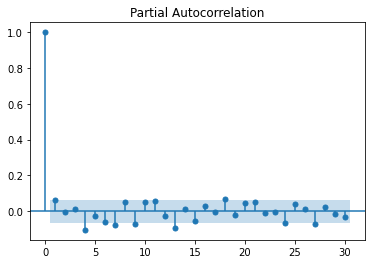

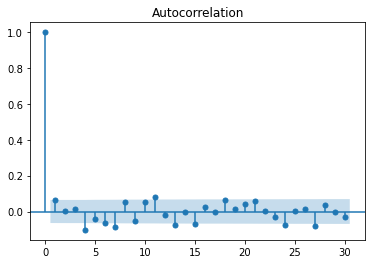

In [63]:
X = df_merge[['sentiment','subjectivity','Num Replies']]
y = df_merge[['Close']]


X_train, y_train= X['2017-01-01':'2020-01-01'],y['2017-01-01':'2020-01-01']
X_test, y_test= X['2020-01-02':],y['2020-01-02':]

plot_pacf(y_train.Close.diff().dropna())
plot_acf(y_train.Close.diff().dropna())
plt.show()

In [64]:
model3=sm.tsa.ARIMA(endog=y_train,exog=X_train,order=[1,1,1])
results3=model3.fit(disp=-1)
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  928
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7262.598
Method:                       css-mle   S.D. of innovations            606.153
Date:                Sat, 24 Apr 2021   AIC                          14539.196
Time:                        11:30:12   BIC                          14573.027
Sample:                             1   HQIC                         14552.100
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -676.2646    318.653     -2.122      0.034   -1300.813     -51.716
sentiment      1716.5937   1590.304      1.079      0.280   -1400.344    4833.532
subjectivity   2250.2266   1094.312     

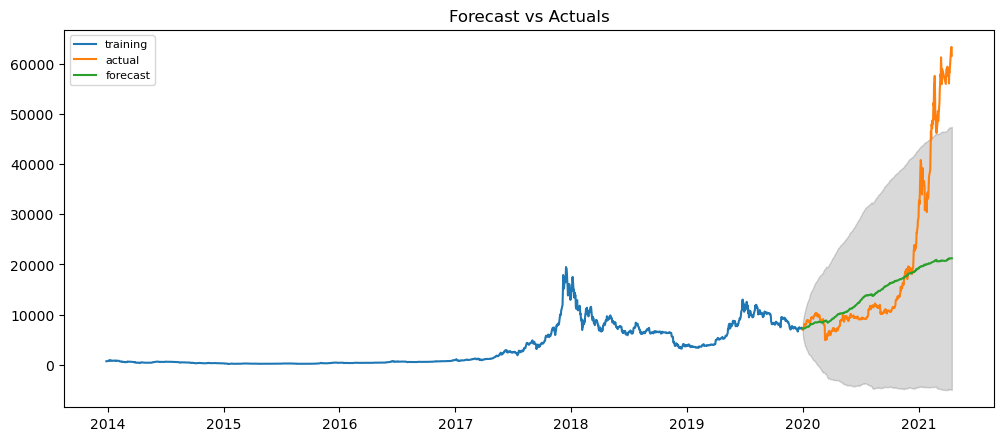

In [95]:
bitcoin=bitcoin.set_index('Date')
Y=bitcoin.loc[: "2020-01-01",:]

fc, se, conf = results3.forecast(exog = X_test,steps=len(X_test),alpha=0.05)
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(Y["Close"], label="training")
plt.plot(y_test, label="actual")
plt.plot(fc_series, label="forecast")
plt.fill_between(lower_series.index, lower_series, upper_series,color="k", alpha=.15)
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [137]:
forecast=pd.DataFrame(fc_series)
forecast = forecast.rename(columns={0: 'Forecast'})
# bitcoin=bitcoin.set_index('Date')
forecast_merge=bitcoin.merge(forecast, how='outer', left_index=True, right_index=True)
forecast_merge.to_csv("Forecasted_data.csv")

In [107]:
X = df_merge[['sentiment','subjectivity','Num Replies']]
y = df_merge['Y']

X_train, y_train= X['2017-01-01':'2020-01-01'],y['2017-01-01':'2020-01-01']
X_test, y_test= X['2020-01-02':],y['2020-01-02':]

In [136]:
#Hyper Parameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split

svm_parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1.0]}
svm_hp = SVC(gamma = 'auto')
svm_cv = GridSearchCV(svm_hp, svm_parameters, n_jobs = -1,return_train_score = True)
svm_cv.fit(X_train, y_train)

forest_clf = RandomForestClassifier(random_state=42)
grid = { 'n_estimators':[4, 16, 50,100, 256],'max_depth': [2, 8, 16,30]}
clf = GridSearchCV(forest_clf, param_grid=grid)
gscv_rfc = clf.fit(X_train, y_train)

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)


print(svm_cv.best_params_, gscv_rfc.best_params_,logreg_cv.best_params_)

{'C': 0.01, 'kernel': 'linear'} {'max_depth': 2, 'n_estimators': 100} {'C': 0.01, 'penalty': 'l2'}


In [125]:
knn_clf = KNeighborsClassifier()
forest_clf = RandomForestClassifier(n_estimators=100, max_depth= 2, random_state=42)
logistic_clf = linear_model.LogisticRegression(solver='liblinear',C= 0.01, penalty= 'l2')
svm_clf = SVC(gamma="auto",probability=True, C=0.01, kernel='linear' )
dectree_clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=100)
gradboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=0)

clfs = {
'Logistic Regression' : logistic_clf,
'Random Forest': forest_clf,
'Gradient Boosting': gradboost_clf, 
'KNN': knn_clf,
'Decision Tree': dectree_clf,   
'SVM': svm_clf,
}

In [126]:
Results_BL = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','F1_score'])
y_pred_list=[]
for model, model_name in zip(clfs.values(), clfs.keys()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score= model.predict_proba(X_test)[:,1]
    Score= cross_val_score(model, X_train, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': model_name,
                     'CV(5)': Score,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred),
                     'Precision_score': metrics.precision_score(y_test, y_pred),
                     'Recall_score': metrics.recall_score(y_test, y_pred),                    
                     'F1_score': metrics.f1_score(y_test, y_pred)
                 })

    y_pred_list.append(y_pred)
    Results_BL = Results_BL.append(t,ignore_index = True)

print('Baseline Model:{} predictors used'.format(X_train.shape[1]))
Results_BL

Baseline Model:3 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,F1_score
0,Logistic Regression,0.540366,0.562780,0.562780,1.000000,0.720230
1,Random Forest,0.529590,0.511211,0.540943,0.868526,0.666667
2,Gradient Boosting,0.504813,0.504484,0.560976,0.549801,0.555332
3,KNN,0.522005,0.538117,0.585551,0.613546,0.599222
4,Decision Tree,0.472531,0.506726,0.565401,0.533865,0.549180
5,SVM,0.540366,0.562780,0.562780,1.000000,0.720230


In [129]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        # Normalize by row sums
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around( 100 * cm_pct, decimals=0).astype(int)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


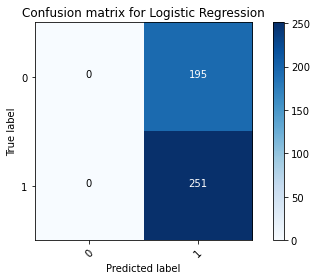

In [130]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[0])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Logistic Regression')

Confusion matrix, without normalization


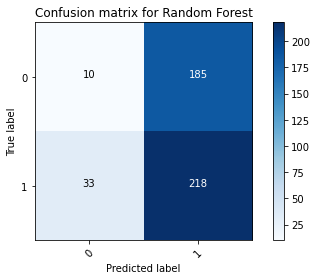

In [131]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[1])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Random Forest')

Confusion matrix, without normalization


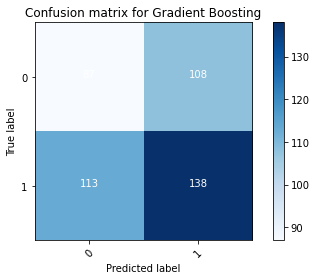

In [132]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[2])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Gradient Boosting')

Confusion matrix, without normalization


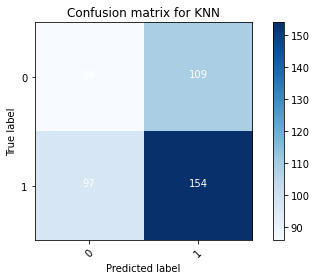

In [133]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[3])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for KNN')

Confusion matrix, without normalization


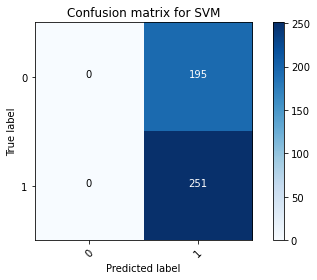

In [134]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[5])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for SVM')

In [135]:
y_pred_list.append(y_test)
new_df=pd.DataFrame(np.vstack(y_pred_list)).T
new_df=new_df.rename(columns={0: 'Logistic Regression',1: 'Random Forest',2: 'Gradient Boosting',3: 'KNN',4: 'Decision Tree',5: 'SVM',6: 'Actual Y'})
new_df.index=y_test.index
new_df=new_df.merge(df_merge[['Return']], how='inner',left_index=True, right_index=True)
new_df.to_csv("Results.csv")